# Using `qgpv_eqlat_lwa`

## Instructions

The python package "hn2016_falwa" contains a wrapper function named "qgpv_eqlat_lwa" that computes the finite-amplitude local wave activity (LWA) based on quasi-geostrophic potential vorticity (QGPV) field derived from Reanalysis data with spherical geometry. It differs from the function "barotropic_eqlat_lwa" that a hemispheric domain (instead of global domain) is used to compute both equivalent-latitude relationship and LWA. This is to avoid spurious large values of LWA near the equator arising from the small meridional gradient of QGPV there.

This sample code demonstrates how the function in this package can be used to reproduce plots of zonal wind, QGPV and LWA plots (Fig.8-9 in HN15) from QGPV fields.

## Contact

Please make inquiries and report issues via Github: https://github.com/csyhuang/hn2016_falwa/issues

In [1]:
from falwa.wrapper import qgpv_eqlat_lwa # Module for plotting local wave activity (LWA) plots and 
                        # the corresponding equivalent-latitude profile
from math import pi
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# --- Parameters --- #
Earth_radius = 6.378e+6 # Earth's radius

# --- Load the zonal wind and QGPV at 240hPa --- #
u_QGPV_File = xr.open_dataset('u_QGPV_240hPa_2012Oct28to31.nc')

# --- Read in longitude and latitude arrays --- #
xlon = u_QGPV_File.longitude.values
ylat = u_QGPV_File.latitude.values
clat = np.abs(np.cos(ylat*pi/180.)) # cosine latitude
nlon = xlon.size
nlat = ylat.size

# --- Parameters needed to use the module HN2015_LWA --- #
dphi = (ylat[2]-ylat[1])*pi/180. # Equal spacing between latitude grid points, in radian
area = 2.*pi*Earth_radius**2 *(np.cos(ylat[:,np.newaxis]*pi/180.)*dphi)/float(nlon) * np.ones((nlat,nlon))
area = np.abs(area) # To make sure area element is always positive (given floating point errors). 

# --- Datestamp ---
Start_date = dt.datetime(2012, 10, 28, 0, 0)
delta_t = dt.timedelta(hours=24)
Datestamp = [Start_date + delta_t*tt for tt in range(4)]

# --- Read in the absolute vorticity field from the netCDF file --- #
u = u_QGPV_File.U.values
QGPV = u_QGPV_File.QGPV.values

# --- Set colorbar range for the 3 variables ---
u_caxis = np.arange(-44,89,11)
LWA_axis = np.linspace(0,313,11,endpoint=True)

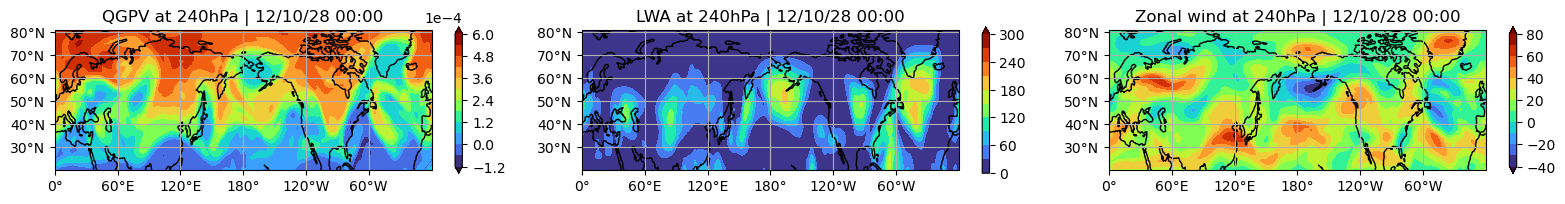

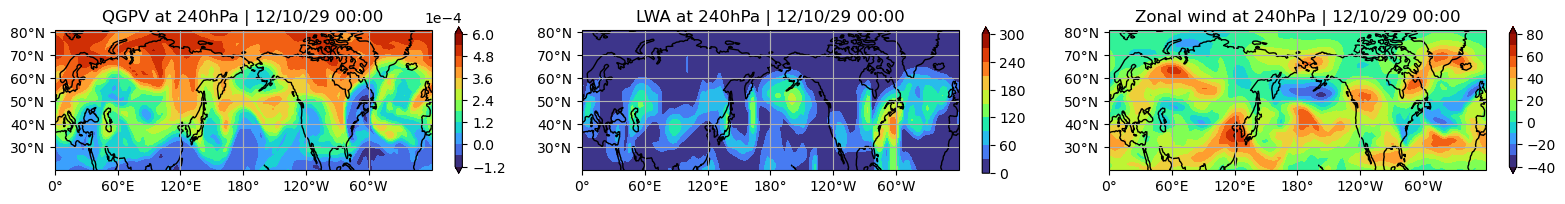

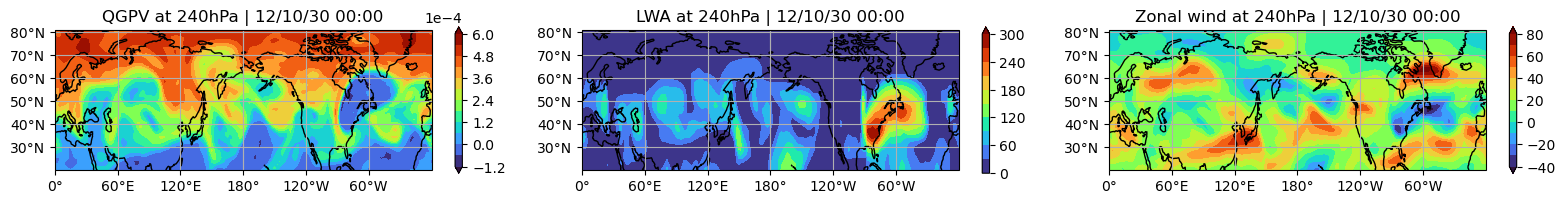

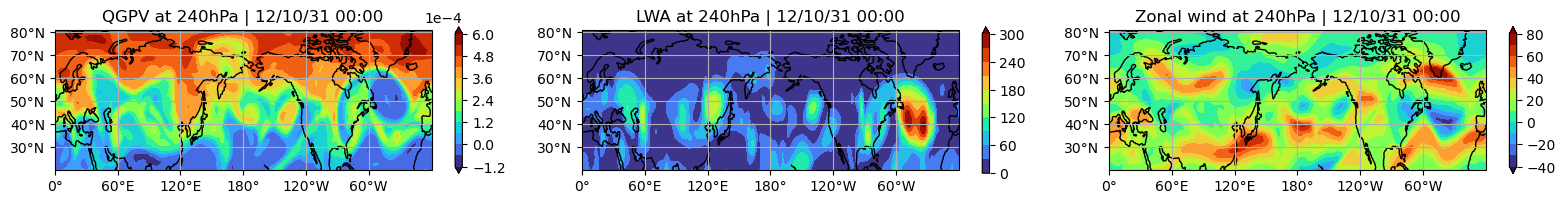

In [2]:
from cartopy.crs import PlateCarree
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.util import add_cyclic_point

projection = PlateCarree(central_longitude=180.)
transform = PlateCarree()

for tt in range(4):
    Qref, LWA = qgpv_eqlat_lwa(ylat, QGPV[tt,0,:,:], area, Earth_radius*clat*dphi)
    
    fig, axs = plt.subplots(1, 3, figsize=(16, 2), subplot_kw={ "projection": projection })
    
    axs[0].set_title(f"QGPV at 240hPa | {Datestamp[tt]:%y/%m/%d %H:%M}")
    QGPV_plot, lons = add_cyclic_point(QGPV[tt,0,:,:], xlon)
    cs = axs[0].contourf(lons, ylat, QGPV_plot, transform=transform, cmap="turbo",
                         levels=np.linspace(-1.2e-4, 6.0e-4, 13), extend="both")
    cb = fig.colorbar(cs, ax=axs[0])
    cb.formatter.set_powerlimits((0, 0))

    axs[1].set_title(f"LWA at 240hPa | {Datestamp[tt]:%y/%m/%d %H:%M}")
    LWA_plot, lons = add_cyclic_point(LWA, xlon)
    cs = axs[1].contourf(lons, ylat, LWA_plot, transform=transform, cmap="turbo",
                         levels=np.linspace(0, 300, 11), extend="max")
    cb = fig.colorbar(cs, ax=axs[1])

    axs[2].set_title(f"Zonal wind at 240hPa | {Datestamp[tt]:%y/%m/%d %H:%M}")
    u_plot, lons = add_cyclic_point(u[tt,0,:,:], xlon)
    cs = axs[2].contourf(lons, ylat, u_plot, transform=transform, cmap="turbo",
                         levels=np.linspace(-40, 80, 13), extend="both")
    cb = fig.colorbar(cs, ax=axs[2])
    
    for ax in axs:
        ax.coastlines()
        ax.set_xticks([0, 60, 120, 180, 240, 300], crs=transform)
        ax.set_yticks([30, 40, 50, 60, 70, 80], crs=transform)
        ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f'))
        ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f'))
        ax.gridlines()
        ax.set_extent([0., 360., 20., 81.], crs=transform)
        ax.set_aspect(2.2)

    fig.tight_layout()